In [1]:
# This is identical to training

import os
# TYPE="Default" #Default, or other custom foldername
TYPE="MyFoler"
isWINDOWS=True
if "Default"==TYPE:
    ROOT_FOLDER="Default"
    LABEL_MAPPING=dict(enumerate([str(i) for i in range(10)]))
    
else:
    ROOT_FOLDER=TYPE
    LABEL_MAPPING=dict(enumerate(["down", "left", "ok", "right", "up"]))
    
#-------Data    
RAW_DATASET_FOLDER=os.path.join(ROOT_FOLDER, "raw_dataset")

#-------Train
VAL_FOLDER=os.path.join(ROOT_FOLDER, "validation")
TRAIN_FOLDER=os.path.join(ROOT_FOLDER, "train")
TEST_FOLDER=os.path.join(ROOT_FOLDER, "test")
CHECK_POINT_FOLDER=os.path.join(ROOT_FOLDER, "checkpoints")

#-------Model
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
TFL_CC_MODEL_FILENAME = "magic_wand_model_data.cc"

SAVED_MODEL_PATH=os.path.join(ROOT_FOLDER, SAVED_MODEL_FILENAME)
FLOAT_TFL_MODEL_PATH=os.path.join(ROOT_FOLDER, FLOAT_TFL_MODEL_FILENAME)
QUANTIZED_TFL_MODEL_PATH=os.path.join(ROOT_FOLDER, QUANTIZED_TFL_MODEL_FILENAME)
TFL_CC_MODEL_PATH=os.path.join(ROOT_FOLDER, TFL_CC_MODEL_FILENAME)

In [2]:
# This is identical to training
## (Optional) print stroke
# import matplotlib.pyplot as plt

# def plot_stroke(one_strokes):
#   x_array = []
#   y_array = []
#   for coords in one_strokes:
#     x_array.append(coords["x"])
#     y_array.append(coords["y"])

#   fig = plt.figure(figsize=(24, 6))
#   fig.suptitle("Test")

#   ax = fig.add_subplot(131)
#   ax.set_xlabel('x')
#   ax.set_ylabel('y')
#   ax.set_xlim(-0.4, 0.4)
#   ax.set_ylim(-0.4, 0.4)
#   ax.plot(x_array, y_array)

#   plt.show()

In [3]:
# This is identical to training
###############################################
## Add stroke sequence color
###############################################
import math
import numpy as np
import PIL

FIXED_POINT = 4096

def mul_fp(a, b):
  return (a * b) // FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) // b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

# 四捨五入 (rounding)
def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT // len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    # This just want to add a Gradient color
    # red->green->blue
    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    #  mainly horizontal
    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    #  mainly vertical
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue
  
  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

In [4]:
# Slightly modified from training
import tensorflow as tf
def predict_tflite(tflite_model_path, img_array):
  # img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  # img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)
  
  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

2
56


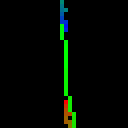

predict:up(4), score:96.0, cost:5.0ms
2
63


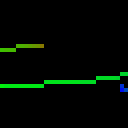

predict:right(3), score:97.0, cost:6.0ms
2
55


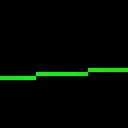

predict:left(1), score:77.0, cost:5.0ms
2
57


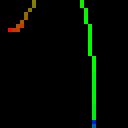

predict:down(0), score:96.0, cost:6.0ms
2
76


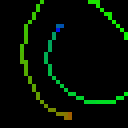

predict:ok(2), score:99.0, cost:5.0ms
2
55


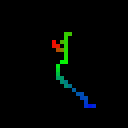

predict:up(4), score:81.0, cost:5.0ms


In [ ]:
import serial
import numpy as np
import re
import time
COM_PORT = 'COM7'    # 指定通訊埠名稱
BAUD_RATES = 9600    # 設定傳輸速率
ser = serial.Serial(COM_PORT, BAUD_RATES)   # 初始化序列通訊埠

try:
    while True:
        while ser.in_waiting:          # 若收到序列資料…
            data_raw = ser.readline()  # 讀取一行
            data = data_raw.decode()   # 用預設的UTF-8解碼
            data2=data.strip()
            data2=re.split('[,\s]', data2)
            if 'AAAAA:' == data2[0]:
                print(data2[1])
                print(data2[2])
                one_strokes = [int(i) for i in data2[3:]]
                one_strokes = np.array(one_strokes) / 128
                strokePoints=[]
                for i in range(len(one_strokes)//2):
                    strokePoints.append({'x':one_strokes[2*i], 
                                         'y':one_strokes[2*i+1]
                                        })
                
                
                # print(one_strokes)
                # plot_stroke(strokePoints)
                
                raster = rasterize_stroke(strokePoints, 0.5, 0.5, 32, 32)
                img = PIL.Image.fromarray(raster).resize((128, 128), PIL.Image.NEAREST)
                display(img)
                                
                start_time = time.time()
                index, score = predict_tflite(QUANTIZED_TFL_MODEL_PATH, raster)
                end_time = time.time()
                print(f"predict:{LABEL_MAPPING[index]}({index}), score:{score*100*100//100}, cost:{(end_time-start_time)*1000*100//100}ms")
            else:
                # print(data)
                pass
except KeyboardInterrupt as ki:
    print(ki)
    print('再見！')
except Exception as e:
    print(e)
    ser.close()    # 清除序列通訊物件
    print('再見！')
